## Test Emotion for Maya

In [22]:
import socket
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataAPI import MayaController
import itertools
import json
import os
from IPython.display import clear_output
from csv import writer

#### Open server

import maya.cmds as cmds

cmds.commandPort(n="localhost:12345")

cmds.commandPort(cl=True, n="localhost:12345")

In [3]:
controller = MayaController()

### Data Interpolation

In [2]:
df = pd.read_csv("../data/emotions.csv")
df

,Name,Brow_L_X,Brow_L_Y,Brow_R_X,Brow_R_Y,Mouth_M_X,Mouth_M_Y,Mouth_M_Lower,Mouth_M_Upper,Mouth_L_X,Mouth_L_Y,Mouth_R_X,Mouth_R_Y,Eye_L_S,Eue_R_S,V,A,D
0,Happy,0.025824,-0.2,0.025824,-0.20,0.40,0.0,0.0,0.0,3.000000e-01,1.00,3.000000e-01,1.00,0.0,0.0,1.000,0.735,0.772
1,Scared,0.500000,0.1,0.500000,0.10,0.20,-0.7,0.0,0.0,2.780000e-17,0.00,2.780000e-17,0.00,0.0,0.0,0.146,0.828,0.185
2,Angry,-0.600000,-0.4,-0.600000,-0.40,0.00,0.0,10.0,10.0,2.780000e-17,-0.20,2.780000e-17,-0.20,7.0,7.0,0.122,0.830,0.604
3,Curious,0.300000,0.0,0.300000,0.00,0.00,-0.3,0.0,0.0,2.780000e-17,0.20,2.780000e-17,0.20,0.0,0.0,0.635,0.600,0.483
4,Neutral,0.000000,0.0,0.000000,0.00,0.00,0.0,0.0,0.0,0.000000e+00,0.00,0.000000e+00,0.00,0.0,0.0,0.469,0.184,0.357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,Confused-Frustrated,-0.250000,-0.2,-0.150000,-0.20,0.05,0.0,7.5,2.5,-1.000000e-01,-0.05,3.000000e-01,-0.40,2.5,3.0,NaN,NaN,NaN
101,Confused-Tired,0.000000,-0.4,0.100000,-0.40,0.05,0.0,8.5,3.5,1.387779e-17,-0.10,2.000000e-01,-0.25,6.0,6.5,NaN,NaN,NaN
102,Shy-Frustrated,0.000000,-0.2,0.150000,-0.15,0.10,0.0,2.5,2.5,-1.000000e-01,0.30,5.000000e-02,-0.10,1.0,1.0,NaN,NaN,NaN
103,Shy-Tired,0.250000,-0.4,0.400000,-0.35,0.10,0.0,3.5,3.5,1.387779e-17,0.25,-5.000000e-02,0.05,4.5,4.5,NaN,NaN,NaN


In [48]:
def print_json(j):
    print(json.dumps(j, indent=4))

def StoreDataToCSV(data: dict, file_path: str, name:str="N/A", vad:list=None):
    '''
    Save the skeleton data to csv
    '''
    emo_lst = [name]
    for attr_dict in data.values():
        for attr in attr_dict.values():
            emo_lst.append(attr)
    if vad:
        emo_lst += vad

    with open(file_path, 'a') as write_obj:
        csv_writer = writer(write_obj)
        csv_writer.writerow(emo_lst)


In [75]:
def EmotionInterpolation(load_dir: str, save_dir: str, n:int =1):
    '''
    Interpolate the emotions and save both the screenshots and the facial attributes as dictionaries
    :param
        load_dir: loading directory of the facial poses
        save_dir: saving directory of the generated screenshots
        n: number of interpolations between poses 
    :return: list of interpolated emotion attributes
    '''
    # Get every poses
    poses_dir = os.listdir(load_dir)
    count = 1

    for strt_pose, end_pose in itertools.combinations(poses_dir, r=2):
        # Get the facial attributes of the starting and ending poses
        strt_dict = controller.GetFacialAttributesFromPose(os.path.join(os.path.join(load_dir, strt_pose), "pose.json"))
        end_dict = controller.GetFacialAttributesFromPose(os.path.join(os.path.join(load_dir, end_pose), "pose.json"))
        new_dict = strt_dict

        # Interpolate new emotions
        for i in range(n):
            for joint, attr_dict in strt_dict.items():
                for name, value in attr_dict.items():
                    diff = (end_dict[joint][name] - value) / (n + 1)
                    new_dict[joint][name] += diff
            
            index_str = strt_pose.split('.')[0]+'-'+end_pose.split('.')[0]
            # Apply Emotion and save a screenshot
            controller.SetFacialAttributes(new_dict)
            controller.ScreenShot(os.path.join(save_dir, index_str))
            # Save joint information to CSV
            StoreDataToCSV(new_dict, "../data/emotions.csv", index_str)

            # This is for debugging
            clear_output(wait=True)
            print(count)
            count += 1

def EmotionInterpolationFromCSV(load_dir: str, cur_num, n:int):
    '''
    Interpolate the emotions and save both the screenshots and the facial attributes as dictionaries
    :param
        load_dir: loading directory of the csv file
        cur_num: number of existing data
        n: number of interpolations between poses 
    :return: list of interpolated emotion attributes
    '''
    # Get every poses
    count = 1

    df = pd.read_csv(load_dir)
    data = df.iloc[:cur_num, :].to_numpy()
    for strt_pose, end_pose in itertools.combinations(data, r=2):
        # Interpolate new emotions
        new_data = np.copy(strt_pose)
        for k in range(n):
            for i in range(1, len(strt_pose)):
                diff = (end_pose[i] - strt_pose[i]) / (n + 1)
                new_data[i] += diff
            
            new_data[0] = strt_pose[0]+'-'+end_pose[0]+'-'+str(k+1)
            # Save joint information to CSV
            with open(load_dir, 'a') as write_obj:
                csv_writer = writer(write_obj)
                csv_writer.writerow(new_data)

            # This is for debugging
            clear_output(wait=True)
            print(count)
            count += 1

In [76]:
# EmotionInterpolation("../StudioLibrary/Poses/Face", "../data/Facial_img", 1)
EmotionInterpolationFromCSV("../data/emotions.csv", 14, 2)

182


### Learning - PCA

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [109]:
def GetData(load_dir):
    df = pd.read_csv(load_dir)
    data = df.iloc[:14, :].to_numpy()
    x = data[:, :15]
    y = data[:, 15:]
    return x, y

In [37]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(x)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.4074713  0.17265272 0.14095791]


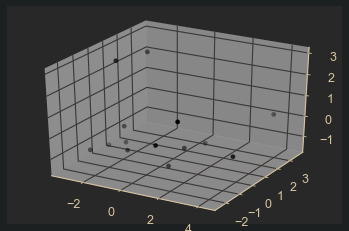

In [41]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(pca_result[:,0], pca_result[:,1], pca_result[:,2], c="black")

### Learning - Nearest Neighbor

In [82]:
def Dist(a, b):
    return sum((i - j) ** 2 for i, j in zip(a,b))

In [96]:
def GenerateFaceFromVAD(vad:list):
    '''
    Generate facial information from VAD vector
    '''
    d = 3
    index = 0
    x, y = GetData('../data/emotions.csv')
    for i, label in enumerate(y):
        dist = Dist(label,)
        if Dist(label, vad) < d:
            d = DIst(label)
            index = i
    return x[index], y[index]

In [116]:
# GenerateFaceFromVAD([0.235,0.82,0.213]) # Nervous <- Scared
# GenerateFaceFromVAD([0.764,0.296,0.559]) # Content <- Curious
# GenerateFaceFromVAD([0.677,0.49,0.696]) # Appraise <- Curious
# GenerateFaceFromVAD([0.104,0.804,0.44]) # Madness <- Disgust
# GenerateFaceFromVAD([0.123,0.423,0.202]) # Exhausted <- Tired

(array(['Curious', 0.3, 0.0, 0.3, 0.0, 0.0, -0.3, 0.0, 0.0, 2.78e-17, 0.2,
        2.78e-17, 0.2, 0.0, 0.0], dtype=object),
 array([0.635, 0.6, 0.483], dtype=object))